# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей.  
Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Загрузка данных

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [13]:
# Датафрейм с разметкой возраста людей
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSets/Appa_Real/labels.csv')

In [14]:
# Тренировочный датаген с аугментациями
train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255, 
                                   horizontal_flip=True,
                                   #zoom_range=0.5,
                                   #brightness_range=(0.5, 1.5)
                                   )

train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/drive/MyDrive/Colab Notebooks/DataSets/Appa_Real/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

Found 6073 validated image filenames.


In [15]:
# Валидационный датаген без аугментаций
validation_datagen = ImageDataGenerator(validation_split=0.2,
                                        rescale=1./255)

val_gen_flow = validation_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/content/drive/MyDrive/Colab Notebooks/DataSets/Appa_Real/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

Found 1518 validated image filenames.


## Изучение данных

In [16]:
labels.info()
labels.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
1826,001826.jpg,39
5669,005669.jpg,38
3920,003920.jpg,39


Пропуски отсутствуют, фотографии пронумерованы и помечены.

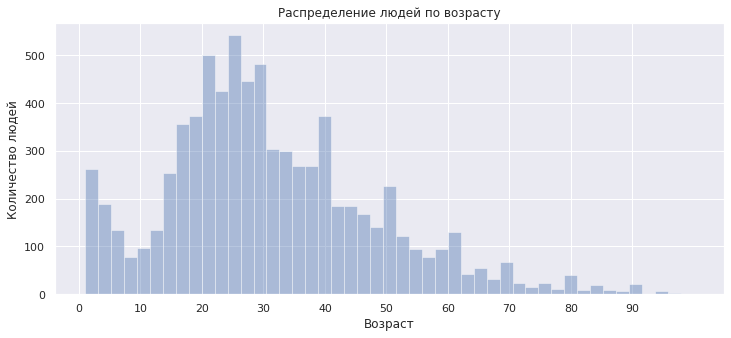

In [17]:
sns.set(style='darkgrid')
plt.figure(figsize=(12, 5))
sns.distplot(labels['real_age'], kde=False)
plt.xticks(range(0, 100, 10))
plt.xlabel('Возраст')
plt.ylabel('Количество людей')
plt.title('Распределение людей по возрасту')
plt.show()

На графике видно сильное смещение датасета в сторону людей помоложе. Это значит, что модель будет не так точно определять людей 40+, как могла бы при полном наборе данных. Так же имеются фотографии детей младше 10 лет, что вряд ли будет полезно в данной ситуации, так как они вряд ли делают покупки в магазинах.

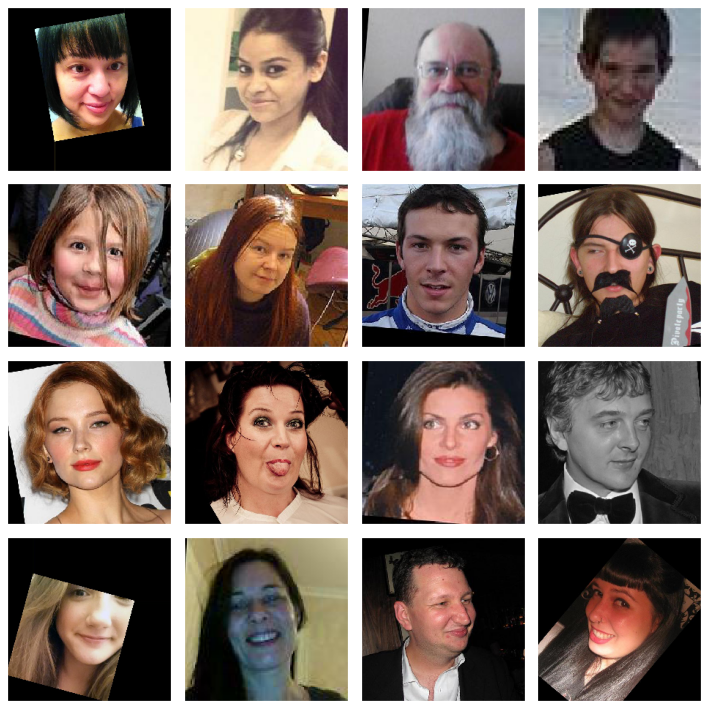

In [18]:
# Вывод батча фотографий
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(next(train_gen_flow)[0][i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Фотографии взяты из открытых источников. Попадаются фотографии знаменитостей, актеров. Так же некоторые фото повернуты, чтобы лица были представлены более-менее вертикально. Присутствуют черно-белые изображения, но они имеют три канала, как и остальные.

## Создание модели

Для предсказания возраста будем использовать ResNet на 50 слоев, предобученную на датасете "imagenet".

In [19]:
backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)

model = Sequential([backbone,
                    Dropout(0.2),
                    GlobalAveragePooling2D(),
                    Dense(1, activation='relu')])

optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])
model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 23,536,641
Non-trainable params: 53,120
_________________________________________________________________


## Обучение и валидация модели

Модель была обучена на сервере яндекса, процесс обучения и результат валидации приведен ниже.

``` python

early_stop = EarlyStopping(patience=4, verbose=1, restore_best_weights=True)

model.fit(train_gen_flow,
            validation_data=val_gen_flow,
            batch_size=16, 
            epochs=1,
            callbacks=[early_stop]
            )

model.save_weights('/content/drive/MyDrive/Colab Notebooks/DataSets/Appa_Real/weights_test.h5')


```

```
Train for 380 steps, validate for 119 steps

Epoch 1/15
380/380 - 48s - loss: 191.0458 - mae: 10.0625 - val_loss: 617.0448 - val_mae: 19.3077
Epoch 2/15
380/380 - 40s - loss: 83.0297 - mae: 6.9001 - val_loss: 144.7937 - val_mae: 8.9838
Epoch 3/15
380/380 - 40s - loss: 57.9142 - mae: 5.7906 - val_loss: 132.2022 - val_mae: 8.9070
Epoch 4/15
380/380 - 40s - loss: 41.8200 - mae: 4.9577 - val_loss: 79.9775 - val_mae: 6.8823
Epoch 5/15
380/380 - 40s - loss: 32.8779 - mae: 4.4163 - val_loss: 62.0716 - val_mae: 5.7222
Epoch 6/15
380/380 - 40s - loss: 25.2283 - mae: 3.8406 - val_loss: 92.2752 - val_mae: 7.5665
Epoch 7/15
380/380 - 40s - loss: 20.2365 - mae: 3.4528 - val_loss: 57.9347 - val_mae: 5.6137
Epoch 8/15
380/380 - 40s - loss: 16.8031 - mae: 3.1190 - val_loss: 76.4515 - val_mae: 6.6621
Epoch 9/15
380/380 - 40s - loss: 15.0243 - mae: 2.9850 - val_loss: 54.0994 - val_mae: 5.2985
Epoch 10/15
380/380 - 40s - loss: 12.8929 - mae: 2.7143 - val_loss: 60.6718 - val_mae: 5.7536
Epoch 11/15
380/380 - 40s - loss: 12.5240 - mae: 2.6940 - val_loss: 51.4179 - val_mae: 5.1948
Epoch 12/15
380/380 - 39s - loss: 13.0711 - mae: 2.7488 - val_loss: 50.9613 - val_mae: 5.2256
Epoch 13/15
380/380 - 40s - loss: 10.9640 - mae: 2.5010 - val_loss: 62.3946 - val_mae: 5.6571
Epoch 14/15
Restoring model weights from the end of the best epoch.
380/380 - 40s - loss: 10.9976 - mae: 2.4977 - val_loss: 54.3884 - val_mae: 5.4256
Epoch 00014: early stopping

119/119 - 9s - loss: 50.9613 - mae: 5.2256
Test MAE: 5.2256
```

## Вывод
Был проведен анализ датасета и дообучена модель ResNet50, предсказывающая возраст людей. В среднем модель ошибается на 5.2 года. Теперь эту модель можно использовать для определения возраста покупателей.